# Dont' use features that require transform to res variables with celmech in tseries. Almost as good as models that include them

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [25]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
featurefolder = 'ressummaryfeaturesxgbv6Norbits10000.0Nout1000/'
resparamfeatures = ['betanear', 'jnear', 'strengthnear', 'C_AMDnear', 'reshalfwidthnear', 'betafar',
                   'jfar', 'strengthfar', 'C_AMDfar', 'reshalfwidthfar', 'betaouter',
                    'secondres', 'reshalfwidthouter', 'jouter', 'C_AMDouter']
tseriesfeatures = ['EMcrossnear', 'EMcrossfar', 'EMcrossouter', 'strengthouter', 
       'tlyap', 'megno', 'EMmednear', 'EMmaxnear', 'EMstdnear', 'EMslopenear', 'EMrollingstdnear',
       'EPmednear', 'EPmaxnear', 'EPstdnear', 'EPslopenear', 'EProllingstdnear', 'EMmedfar', 'EMmaxfar',
       'EMstdfar', 'EMslopefar', 'EMrollingstdfar', 'EPmedfar', 'EPmaxfar', 'EPstdfar', 'EPslopefar',
       'EProllingstdfar', 'EMmedouter', 'EMmaxouter', 'EMstdouter', 'AMDerr',
       'EMslopeouter', 'EMrollingstdouter', 'EPmedouter', 'EPmaxouter',
       'EPstdouter', 'EPslopeouter', 'EProllingstdouter']

features = resparamfeatures + tseriesfeatures

In [26]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

In [27]:
trainX.shape

(7999, 52)

In [28]:
trainX.columns

Index(['betanear', 'jnear', 'strengthnear', 'C_AMDnear', 'reshalfwidthnear',
       'betafar', 'jfar', 'strengthfar', 'C_AMDfar', 'reshalfwidthfar',
       'betaouter', 'secondres', 'reshalfwidthouter', 'jouter', 'C_AMDouter',
       'EMcrossnear', 'EMcrossfar', 'EMcrossouter', 'strengthouter', 'tlyap',
       'megno', 'EMmednear', 'EMmaxnear', 'EMstdnear', 'EMslopenear',
       'EMrollingstdnear', 'EPmednear', 'EPmaxnear', 'EPstdnear',
       'EPslopenear', 'EProllingstdnear', 'EMmedfar', 'EMmaxfar', 'EMstdfar',
       'EMslopefar', 'EMrollingstdfar', 'EPmedfar', 'EPmaxfar', 'EPstdfar',
       'EPslopefar', 'EProllingstdfar', 'EMmedouter', 'EMmaxouter',
       'EMstdouter', 'AMDerr', 'EMslopeouter', 'EMrollingstdouter',
       'EPmedouter', 'EPmaxouter', 'EPstdouter', 'EPslopeouter',
       'EProllingstdouter'],
      dtype='object')

In [29]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "aucpr", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-aucpr-mean"])
    error = np.mean(score["test-aucpr-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    precision, recall, thresh = metrics.precision_recall_curve(testY, preds)
    test_score = metrics.auc(recall, precision)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [8]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.83750088                                          
ERROR                                               
0.014059086541910928                                
HOLDOUT SCORE                                       
0.8719830466566145                                  
SCORE:                                                                        
0.8318989200000001                                                            
ERROR                                                                         
0.012595104951192043                                                          
HOLDOUT SCORE                                                                 
0.8739342057027562                                                            
SCORE:                                                                        
0.8186541199999999                                                            
ERROR                                             

0.7820765709218788                                                           
SCORE:                                                                       
0.7398939999999999                                                           
ERROR                                                                        
0.021213995386989922                                                         
HOLDOUT SCORE                                                                
0.8101327596677907                                                           
SCORE:                                                                       
0.82672986                                                                   
ERROR                                                                        
0.007510467712392039                                                         
HOLDOUT SCORE                                                                
0.8764128089398726                                              

0.83736448                                                                    
ERROR                                                                         
0.00994279889832708                                                           
HOLDOUT SCORE                                                                 
0.8740818515810932                                                            
SCORE:                                                                        
0.8282872400000001                                                            
ERROR                                                                         
0.01417979206888135                                                           
HOLDOUT SCORE                                                                 
0.8728287458003441                                                            
SCORE:                                                                        
0.8329751                                           

In [9]:
best

{'x_learning_rate': 0.17832643520601693,
 'x_max_depth': 16,
 'x_min_child': 6.0,
 'x_pos_weight': 14.037240652488686,
 'x_subsample': 0.9984912784752125,
 'x_tree_colsample': 0.9953671794157032}

In [10]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "aucpr", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-aucpr:0.837586+0.0128853	test-aucpr:0.730837+0.017054
[1]	train-aucpr:0.902433+0.0108747	test-aucpr:0.762664+0.0166592
[2]	train-aucpr:0.92616+0.0126319	test-aucpr:0.787985+0.0184324
[3]	train-aucpr:0.948391+0.0120764	test-aucpr:0.804103+0.0173957
[4]	train-aucpr:0.960536+0.00869647	test-aucpr:0.812125+0.0166902
[5]	train-aucpr:0.968811+0.0055783	test-aucpr:0.822654+0.0174609
[6]	train-aucpr:0.974615+0.00505891	test-aucpr:0.824881+0.0205577
[7]	train-aucpr:0.980237+0.0029007	test-aucpr:0.830612+0.0198443
[8]	train-aucpr:0.984276+0.0024211	test-aucpr:0.835076+0.0201407
[9]	train-aucpr:0.988311+0.00159517	test-aucpr:0.843052+0.0175203
   train-aucpr-mean  train-aucpr-std  test-aucpr-mean  test-aucpr-std
0          0.837586         0.012885         0.730837        0.017054
1          0.902433         0.010875         0.762664        0.016659
2          0.926160         0.012632         0.787985        0.018432
3          0.948391         0.012076         0.804103        0.017396

In [11]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY, eval_metric='aucpr')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.9953671794157032, gamma=0,
              learning_rate=0.17832643520601693, max_delta_step=0, max_depth=16,
              min_child_weight=6.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=14.037240652488686,
              seed=None, silent=True, subsample=0.9984912784752125)

In [15]:
dill.dump([model, features, featurefolder], open(datapath+"../models/ressummaryfeaturesxgbv6_resonant.pkl", "wb"))

Text(0.5, 1.0, 'ROC curve (AUC = 0.958)')

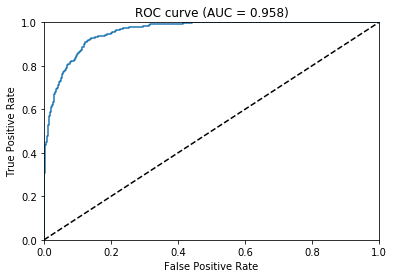

In [12]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [13]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.0020656392443925142, recall = 1.0, precision = 0.45577085088458297
Threshold 0.0022819270379841328, recall = 0.9963031423290203, precision = 0.4598976109215017
Threshold 0.0025787248741835356, recall = 0.9963031423290203, precision = 0.4658599827139153
Threshold 0.002826543990522623, recall = 0.9944547134935305, precision = 0.4711033274956217
Threshold 0.0033040361013263464, recall = 0.9944547134935305, precision = 0.47737355811889975
Threshold 0.003664695657789707, recall = 0.9944547134935305, precision = 0.48381294964028776
Threshold 0.004304214380681515, recall = 0.9944547134935305, precision = 0.49042844120328166
Threshold 0.004718983080238104, recall = 0.9944547134935305, precision = 0.49722735674676527
Threshold 0.0052010840736329556, recall = 0.9944547134935305, precision = 0.5042174320524836
Threshold 0.005999431479722261, recall = 0.9944547134935305, precision = 0.5114068441064639
Threshold 0.006838237401098013, recall = 0.9926062846580407, precision = 0.5178399228

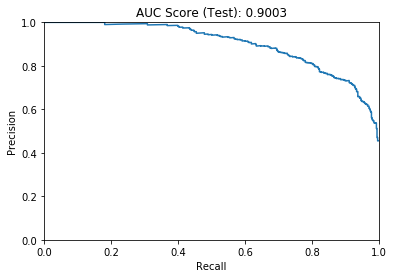

In [14]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 223.3)

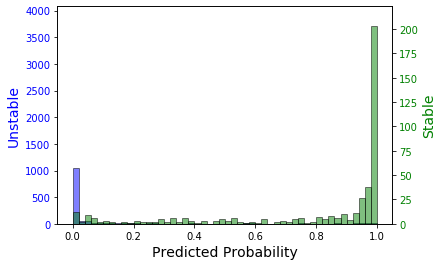

In [16]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,20.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

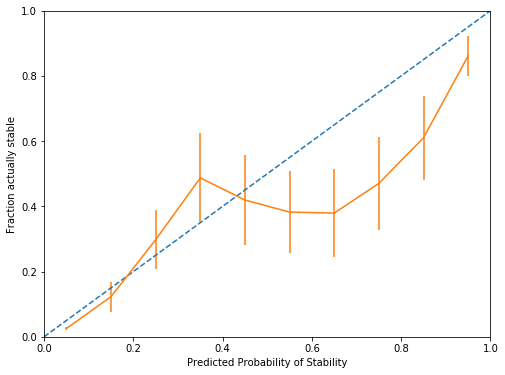

In [17]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

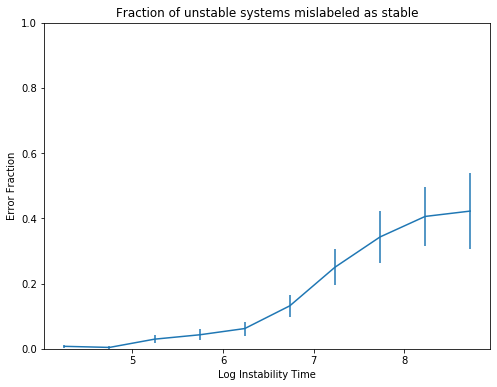

In [18]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

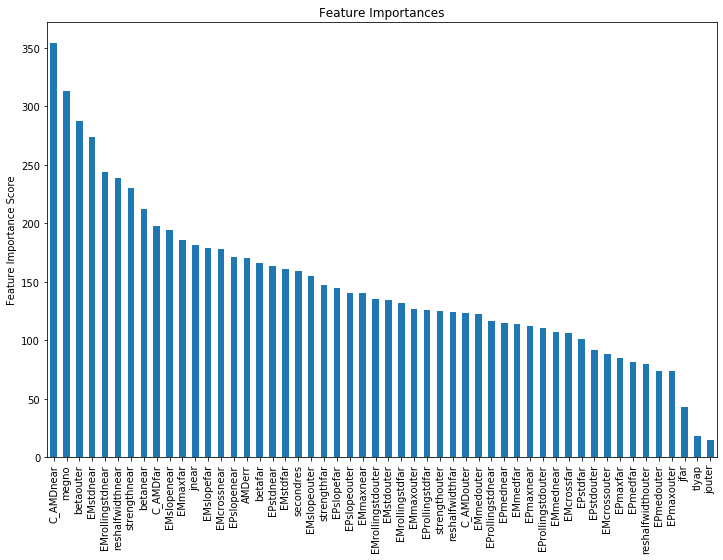

In [19]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# things that are just unstable might be very similar to things that are just stable

# predict at half a billion, then repredict at half a billion whether you'll be unstable at a billion

# do the summary features change with time?

# We care about probability it is unstable when we predict unstable. Look at these errors specifically